In [1]:
!rm -rf star_wars

import numpy as np
import torch
import os
import cv2
import random
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet34
from google.colab import auth
from googleapiclient.discovery import build
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt

Сегодня мы будем использовать transfer learning чтобы обучить классификатор героев классических звёздных войн. Эта практика требует обучения на GPU (иначе код будет выполнятся очень долго), поэтому используйте https://colab.research.google.com.

Сначала нужно включить поддержку GPU. Зайдите в Edit -> Notebook settings и как hardware accelerator укажите GPU.

Теперь нужно скачать данные, выполните следующую ячейку.
В первый раз она попросит вас перейти по ссылке - откройте эту ссылку и скопируйте оттуда токен (длинную строку в base64), вставьте этот токен в окошко под ячейкой.

In [2]:
def download_data(file_id, file_name):
  import io
  from googleapiclient.http import MediaIoBaseDownload

  request = drive_service.files().get_media(fileId=file_id)
  downloaded = io.BytesIO()
  downloader = MediaIoBaseDownload(downloaded, request)
  done = False
  while done is False:
    _, done = downloader.next_chunk()
    
  downloaded.seek(0)
  with open(file_name, "wb") as f:
    f.write(downloaded.read())

  
auth.authenticate_user()
drive_service = build('drive', 'v3')

file_id = '139wA_Z9kustXy54ifhWWHJvARo5f7O6y'
file_name = 'star_wars.tar.gz'

download_data(file_id, file_name)
!tar xf star_wars.tar.gz

Важная часть обучения нейронных сетей (как и обычно в машинном обучении)  - это работа с данными. Необходимо представить данные в векторном виде и отдать их модели для обучения. В фреймворке Pytorch для этого используется связка двух классов: https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset и https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader. 

Первый это даже не класс, а интерфейс - у него всего два интересных метода:
__getitem__ - выбрать из датасета элемент по заданному числовому индексу
__len__ - вернуть длину датасета.



DataLoader в свою очередь занимается тем что выбирает элементы из Dataset который передается ему в конструкторе и делает из них батчи для обучения нейронной сети. Вы можете контролировать размер батча с помощью параметра batch_size, также не забудьте включать перемешивание данных перед каждой эпохой передавая в DataLoader параметр shuffle=True. В более продвинутых случаях возможно задавать стратегию того как именно конструируются батчи с помощью классов Sampler и BatchSampler, но мы в нашей практике этих возможностей касаться не будем.

Главное отличие Dataset от массива на практике в том что этот интерфейс не обязывает вас хранить весь набор данных в памяти. Типичная реализация по индексу подгружает данные с диска и делает из них сэмпл. 

Я создал 4 папки и скачал в них картинки с помощью https://github.com/hardikvasa/google-images-download

Это делается очень просто:

```
pip install google_images_download
googleimagesdownload -k "люк скайуокер"
```
Гугл ограничивает количество картинок, которые можно скачать по поисковому запросу, но это можно обойти либо скачивать с других мест, где нет ограничений (напр. Yandex или Instagram)


В итоге у нас получилась следующая структура на диске:

```
root/люк скайуокер/xxx.jpg
root/люк скайуокер/xxy.jpeg
root/люк скайуокер/xxz.png

root/чубакка/123.png
root/чубакка/nsdf3.jpg
root/чубакка/asd932_.gif
```

По сколько это просто выдача гугла, тут встречаются как .jpg и .png так и .gif

Удобнее всего (по крайней мере мне), когда у вас есть 2 массива - один с путями к файлам и другой с лейблами для них. Давайте я сделаю его за вас:

In [3]:
filenames = []
labels = []
for idx, class_dir in enumerate(os.listdir("star_wars")):
  print(f"берем файлы из папки \"{class_dir}\" и даем им класс {idx}")
  
  # не берем файлы кроме .jpg .jpeg и .png
  for file in os.listdir(os.path.join("star_wars", class_dir)):
    if not file.endswith(('.jpg', '.jpeg', '.png')):
      continue
      
    filenames.append(os.path.join("star_wars", class_dir, file))
    labels.append(idx)

берем файлы из папки "дарт вейдер" и даем им класс 0
берем файлы из папки "люк скайуокер" и даем им класс 1
берем файлы из папки "чубакка" и даем им класс 2
берем файлы из папки "принцесса лея" и даем им класс 3


Это типичная ситуация, как у вас могут оказаться данные на руках (а не непонятный массив как было c MNIST)

2


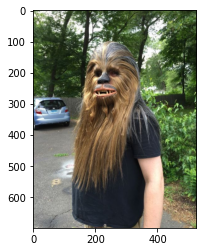

In [4]:
# будем брать по 1 рандомной картинке, выводить ее и смотреть на класс. Так в реально жизни можно проверить не *** ли вы скачали и верные ли классы
# можете выполнять этот cell пока не надоест
random_index = np.random.choice(range(len(filenames)))
test_img = cv2.imread(filenames[random_index])[:, :, ::-1] # эта штука в конце равносильно переводу из BGR в RGB
print(labels[random_index])
plt.imshow(test_img)

In [5]:
# Задание 1. Разбейте filenames и labels на train и test части 70/30
train_filenames, test_filenames, train_labels, test_labels = train_test_split(filenames, labels,
                                                                              train_size=0.7, test_size=0.3,
                                                                              random_state=42)

print(train_labels)

[2, 3, 3, 2, 0, 3, 0, 2, 0, 3, 1, 3, 1, 0, 0, 1, 1, 3, 3, 1, 3, 0, 1, 3, 0, 3, 2, 0, 2, 1, 0, 1, 2, 2, 2, 3, 2, 0, 0, 2, 1, 1, 3, 1, 2, 0, 0, 0, 1, 1, 0, 2, 3, 1, 1, 1, 2, 0, 3, 1, 3, 3, 2, 1, 2, 1, 3, 1, 0, 0, 2, 3, 1, 1, 2, 2, 1, 3, 3, 3, 3, 1, 3, 2, 1, 2, 0, 1, 2, 3, 2, 1, 3, 2, 3, 1, 0, 3, 0, 0, 3, 1, 2, 2, 1, 2, 2, 0, 3, 0, 2, 0, 2, 0, 1, 0, 0, 0, 1, 1, 1, 2, 2, 1, 3, 0, 3, 1, 2, 1, 2, 1, 0, 0, 3, 2, 1, 0, 3, 1, 2, 3, 0, 0, 3, 3, 3, 1, 2, 3, 2, 1, 1, 2, 0, 0, 0, 2, 3, 0, 3, 2, 2, 1, 3, 1, 0, 1, 1, 0, 0, 0, 1, 0, 3, 3, 2, 3, 3, 2, 2, 2, 3, 2, 3, 3, 2, 2, 1, 0, 2, 2, 2, 1, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 2, 0, 0, 2, 1, 3, 1, 3, 3, 3, 2, 0, 0, 1, 2, 3, 2, 1, 0, 0, 2, 2, 0, 3, 1, 3, 2, 3, 2, 3, 1, 1, 1, 1, 0, 3, 2, 1, 3, 0, 2, 0, 1, 2, 3, 1]


Теперь нашей основной задачей является создание Dataset и Dataloader для наших данных. Их должно быть два: один для train, другой для test.

Мы собираемся использовать transfer learning - взять сеть предобученную на ImageNet и доучить её на наших изображениях. Сети тренировавшиеся на ImageNet требуют стандартного размера картинок: 224x224.

Нам нужно поресайзить картинки и делать их квадратными. Я подготовил вам два метода для ресайза и для добавление 'ушей' к изображению если оно не квадратное. Вы должны поюзать их в своем классе Dataset. 

In [6]:
def add_pad(img, shape):
    color_pick = img[0][0]
    padded_img = color_pick * np.ones(shape + img.shape[2:3], dtype=np.uint8)
    x_offset = int((padded_img.shape[0] - img.shape[0]) / 2)
    y_offset = int((padded_img.shape[1] - img.shape[1]) / 2)
    padded_img[x_offset:x_offset + img.shape[0], y_offset:y_offset + img.shape[1]] = img

    return padded_img


def resize(img, shape):
    scale = min(shape[0] * 1.0 / img.shape[0], shape[1] * 1.0 / img.shape[1])
    if scale != 1:
        img = cv2.resize(img, dsize=None, fx=scale, fy=scale, interpolation=cv2.INTER_LINEAR)
    return img


In [42]:
from skimage import color

# Задание 2. Реализуйте класс-наследник Dataset. Он должен возвращать по индексу 
class StarWarsDataset(Dataset):
    def __init__(self, filenames, labels):
        self._filenames = filenames
        self._labels = labels

    def __len__(self):
        return len(self._filenames)

    def __getitem__(self, idx):
        # dataloader запросит какой-то индекс (но не больше чем значение __len__)
        # мы должны отдать ему image в виде массива и соотвуствующий ему label
        filename = self._filenames[idx]
        label = self._labels[idx]
        
        # мы получили имя файла, теперь нужно загрузить картинку как numpy array 
        # и изменить размер так, чтобы он был 224 на 224
        img = cv2.imread(filename)
        #if random.random() < 10:
        #  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        img = resize(img, (224, 224))
        img = add_pad(img, (224, 224))
        
        
        # меняем порядок каналов и делим все на 255, оборачиваем в torch tensor
        # это просто надо делать, потом спросите зачем
        img = torch.tensor(img, dtype=torch.float).permute(2, 0, 1) / 255.

        return img, label

Мы написали типичный класс-наследник Dataset для данных такого формата и поресайзили изображение к размеру 224х224 + преобразовали его в тензор внутри него. Теперь нужно создать Dataloader - да штука, которая просит возвращать Dataset данные по idx и составляет их них батчи.

In [43]:
train_dataset = StarWarsDataset(train_filenames, train_labels)
train_dataloder = DataLoader(train_dataset, shuffle=True, batch_size=64, num_workers=0)

In [44]:
# Задание 3. Сделайте dataloader для test
test_dataset = StarWarsDataset(test_filenames, test_labels)
test_dataloder = DataLoader(test_dataset, shuffle=True, batch_size=64, num_workers=0)

Завайте посмотрим что выводит ваш тестовый Dataloader...

In [45]:
for batch in test_dataloder: # получаем 1 batch - 1 итерация подгрузки данных
  images, labels = batch     # наш Dataset возвращает tuple, поэтому мы можем сделать так
  print(f'Всего батчей по batch_size: {len(train_dataloder)}')
  print(f'Лейбл первого элемента в первом батче: {labels[0]}')
  print(f'Размер картинки в первом батче: {images[0].shape}')
  break

Всего батчей по batch_size: 4
Лейбл первого элемента в первом батче: 0
Размер картинки в первом батче: torch.Size([3, 224, 224])


In [49]:
# Здесь мы берем предобученный resnet34 и заменяем в нём последний слой на голову классифицирующую изображение на 1 из 4 классов
# Берём кросс энтропию в качестве лосса и оптимизатор адам
# Мы замораживаем все слои сети кроме последнего, который будем обучать далее

model = resnet34(pretrained=True) # resnet обученный на ImageNet
for param in model.parameters():
  param.requires_grad=False

num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 4)
model.to('cuda')

# loss и optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [47]:
# можно принтануть модель и уведеть какие в ней слои
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Как я и говорил, transfer learning - это очень просто. В resnet куча сверток и пулингов, в конце fully connected слой на 1000. Мы удаляет последний слой, заменяя его новым на с выходом на 4 класса. Так, свертки внутри модели помнят все фичи умеют распознавать классы из ImageNet, мы просто помогаем их скорректировать на наших данных  

In [50]:
#Эта функция считает точность модели - на вход передается сама модель, номер эпохи и тестовый лоадер.

def run_test_on_epoch(model, epoch, test_loader):
    model.eval()
    with torch.no_grad():
      test_accuracy = []
      test_real = []
      for batch_x, batch_y in tqdm(test_loader):
          outputs = model(batch_x.to('cuda')).detach().cpu().numpy()
          test_accuracy.append(outputs)
          test_real.append(batch_y.detach().cpu().numpy())
      print("Epoch", epoch, "test accuracy", accuracy_score(np.hstack(test_real), np.argmax(np.vstack(test_accuracy), axis=1)))
    model.train()

In [51]:
# Задание 5. Напишите код для обучения модели 25 эпох. В конце каждой эпохи вызывайте run_test_on_epoch() чтобы следить за точностью
for epoch in tqdm(range(25)):
  for i, (feats, labels) in enumerate(train_dataloder):
    feats = feats.to(torch.device('cuda'))
    labels = labels.to(torch.device('cuda'))

    optimizer.zero_grad()

    preds = model(feats)

    loss = criterion(preds, labels)
    loss.backward()

    optimizer.step()
  
  # половину сделал за вас
  run_test_on_epoch(model, epoch, test_dataloder)
       

  4%|▍         | 1/25 [00:04<01:43,  4.30s/it]

Epoch 0 test accuracy 0.37962962962962965



  8%|▊         | 2/25 [00:08<01:37,  4.23s/it]

Epoch 1 test accuracy 0.42592592592592593



 12%|█▏        | 3/25 [00:12<01:32,  4.20s/it]

Epoch 2 test accuracy 0.49074074074074076



 16%|█▌        | 4/25 [00:16<01:27,  4.16s/it]

Epoch 3 test accuracy 0.5370370370370371



 20%|██        | 5/25 [00:20<01:23,  4.15s/it]

Epoch 4 test accuracy 0.6296296296296297



 24%|██▍       | 6/25 [00:24<01:18,  4.15s/it]

Epoch 5 test accuracy 0.6759259259259259



 28%|██▊       | 7/25 [00:28<01:14,  4.14s/it]

Epoch 6 test accuracy 0.7314814814814815



 32%|███▏      | 8/25 [00:33<01:10,  4.16s/it]

Epoch 7 test accuracy 0.75



 36%|███▌      | 9/25 [00:37<01:06,  4.14s/it]

Epoch 8 test accuracy 0.7962962962962963



 40%|████      | 10/25 [00:41<01:01,  4.12s/it]

Epoch 9 test accuracy 0.7870370370370371



 44%|████▍     | 11/25 [00:45<00:57,  4.09s/it]

Epoch 10 test accuracy 0.7870370370370371



 48%|████▊     | 12/25 [00:49<00:53,  4.09s/it]

Epoch 11 test accuracy 0.8055555555555556



 52%|█████▏    | 13/25 [00:53<00:48,  4.08s/it]

Epoch 12 test accuracy 0.8148148148148148



 56%|█████▌    | 14/25 [00:57<00:44,  4.08s/it]

Epoch 13 test accuracy 0.8240740740740741



 60%|██████    | 15/25 [01:01<00:40,  4.07s/it]

Epoch 14 test accuracy 0.8518518518518519



 64%|██████▍   | 16/25 [01:05<00:36,  4.06s/it]

Epoch 15 test accuracy 0.8333333333333334



 68%|██████▊   | 17/25 [01:09<00:32,  4.07s/it]

Epoch 16 test accuracy 0.8518518518518519



 72%|███████▏  | 18/25 [01:13<00:28,  4.07s/it]

Epoch 17 test accuracy 0.8518518518518519



 76%|███████▌  | 19/25 [01:17<00:24,  4.09s/it]

Epoch 18 test accuracy 0.8518518518518519



 80%|████████  | 20/25 [01:22<00:20,  4.11s/it]

Epoch 19 test accuracy 0.8518518518518519



 84%|████████▍ | 21/25 [01:26<00:16,  4.10s/it]

Epoch 20 test accuracy 0.8611111111111112



 88%|████████▊ | 22/25 [01:30<00:12,  4.12s/it]

Epoch 21 test accuracy 0.8611111111111112



 92%|█████████▏| 23/25 [01:34<00:08,  4.12s/it]

Epoch 22 test accuracy 0.8703703703703703



 96%|█████████▌| 24/25 [01:38<00:04,  4.13s/it]

Epoch 23 test accuracy 0.8796296296296297



100%|██████████| 25/25 [01:42<00:00,  4.11s/it]

Epoch 24 test accuracy 0.8796296296296297


Какая точность у вас получилась?

Дополнительные задания:
 1. Скачать свои данные и обучить на них
 2. Добавить агументации в класс StarWarsDataset (например, не только resize и add_pad а конвертацию в grayscale в 10% случаях или сглаживание)